In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold # import KFold

import numpy as np
import time
import os, os.path, sys
import copy
import glob
import shutil
import matplotlib.pylab as plt
import matplotlib.animation as animation

import visdom

plt.ion()   # interactive mode

In [2]:
# 학습을 위한 데이터 증가(Augmentation)와 일반화하기
# 단지 검증을 위한 일반화하기
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 이 부분
# K-Cross Validation 공부해서
# Train / Validation 나누면 좋겠다
data_dir = 'dataset_cross'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [3]:
vis = visdom.Visdom()
loss_window = vis.line(X=torch.zeros((1,)).cpu(),
                        Y=torch.zeros((1)).cpu(),
                        opts=dict(xlabel='epoch',
                                  ylabel='Loss',
                                  title='Loss'))    
vis = visdom.Visdom()
accuracy_window = vis.line(X=torch.zeros((1,)).cpu(),
                           Y=torch.zeros((1)).cpu(),
                           opts=dict(xlabel='epoch',
                                     ylabel='accuracy',
                                     title='Accuracy'))

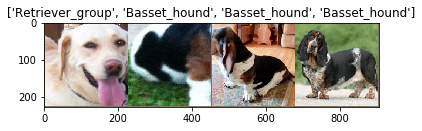

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            vis.line(
                        X=torch.ones((1, 1)).cpu()*epoch,
                        Y=torch.Tensor([epoch_loss]).unsqueeze(0).cpu(),
                        win=loss_window,
                        name=phase + ' Loss',
                        update='append')
        
            vis.line(
                        X=torch.ones((1, 1)).cpu()*epoch,
                        Y=torch.Tensor([epoch_acc]).unsqueeze(0).cpu(),
                        win=accuracy_window,
                        name=phase + ' Accuracy',
                        update='append')
                                             
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
                # 최고 정확도가 현재 정확도를 넘어야지만 출력되게 되어있음
                time_elapsed = time.time() - since
                print('Training Time Check : {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))
                print('Best val Acc: {:4f}'.format(best_acc))
                              

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

In [7]:
model_ft = models.resnet152(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19

----------

train Loss: 1.9641 Acc: 0.4902

val Loss: 0.6941 Acc: 0.8363

Training Time Check : 11m 21s

Best val Acc: 0.836296

Epoch 1/19

----------

train Loss: 1.2276 Acc: 0.6664

val Loss: 0.9098 Acc: 0.8400

Training Time Check : 22m 46s

Best val Acc: 0.840000

Epoch 2/19

----------

train Loss: 1.0275 Acc: 0.7114

val Loss: 1.9288 Acc: 0.8326

Epoch 3/19

----------

train Loss: 0.9265 Acc: 0.7406

val Loss: 0.3757 Acc: 0.9111

Training Time Check : 45m 36s

Best val Acc: 0.911111

Epoch 4/19

----------

train Loss: 0.8485 Acc: 0.7615

val Loss: 0.4959 Acc: 0.8948

Epoch 5/19

----------

train Loss: 0.7809 Acc: 0.7773

val Loss: 0.4537 Acc: 0.9081

Epoch 6/19

----------

train Loss: 0.7141 Acc: 0.7987

val Loss: 0.4149 Acc: 0.9000

Epoch 7/19

----------

train Loss: 0.4937 Acc: 0.8568

val Loss: 0.1742 Acc: 0.9533

Training Time Check : 91m 23s

Best val Acc: 0.953333

Epoch 8/19

----------

train Loss: 0.4394 Acc: 0.8766

val Loss: 0.1504 Acc: 0.9541

Training Time Check : 102m 50s

Best val Acc: 0.954074

Epoch 9/19

----------

train Loss: 0.3832 Acc: 0.8927

val Loss: 0.1342 Acc: 0.9615

Training Time Check : 114m 15s

Best val Acc: 0.961481

Epoch 10/19

----------

train Loss: 0.3815 Acc: 0.8918

val Loss: 0.1286 Acc: 0.9667

Training Time Check : 125m 39s

Best val Acc: 0.966667

Epoch 11/19

----------

train Loss: 0.3699 Acc: 0.8915

val Loss: 0.1398 Acc: 0.9585

Epoch 12/19

----------

train Loss: 0.3711 Acc: 0.8954

val Loss: 0.1181 Acc: 0.9667

Epoch 13/19

----------

train Loss: 0.3570 Acc: 0.8968

val Loss: 0.1508 Acc: 0.9593

Epoch 14/19

----------

train Loss: 0.3279 Acc: 0.9023

val Loss: 0.1140 Acc: 0.9667

Epoch 15/19

----------

train Loss: 0.3350 Acc: 0.9022

val Loss: 0.1215 Acc: 0.9689

Training Time Check : 182m 56s

Best val Acc: 0.968889

Epoch 16/19

----------

train Loss: 0.3282 Acc: 0.9058

val Loss: 0.1268 Acc: 0.9659

Epoch 17/19

----------

train Loss: 0.3256 Acc: 0.9061

val Loss: 0.1141 Acc: 0.9689

Epoch 18/19

----------

train Loss: 0.3224 Acc: 0.9072

val Loss: 0.1266 Acc: 0.9674

Epoch 19/19

----------

train Loss: 0.3214 Acc: 0.9083

val Loss: 0.1256 Acc: 0.9659

Training complete in 228m 51s

Best val Acc: 0.968889

In [2]:
# 없는 val, sub_category 폴더 생성
data_dir = 'dataset_cross'

folders = np.array(glob.glob(os.path.join(data_dir + '/train/**/')))
folder_items = np.array(glob.glob(os.path.join(data_dir + '/train/**/','*')))

# 폴더 정보
nb_folders = len(folders)
folder_idx = np.arange(nb_folders)
# 폴더 내부 sub_folder 정보
nb_folder_items = len(folder_items)
folder_item_idx = np.arange(nb_folder_items)

# Val folder 가 존재하면 생성 X
if(os.path.exists(data_dir+'/val') == False) :
    os.mkdir(data_dir+'/val')

# 전체 카테고리 개수
# print(nb_folders)

# 전체 index 배열
# print(folder_idx)
   
# 각각의 카테고리별로 45번 반복
# Val 카테고리로 이동
for i in range(nb_folders): 
    # folder 가 존재하면 생성 X
    if(os.path.exists(data_dir+'/val'+ folders[i][19:]) == False):
        # folders 개수 만큼 Val 폴더 안에 동일한 폴더 생성
        os.mkdir(data_dir + '/val' + folders[i][19:])
        # 카테고리 생성 완료
    
print("\n 폴더 생성 완료")
# train -> val 이동 완료


 폴더 생성 완료

In [4]:
for i in range(nb_folders): 
    start_folder = data_dir+'/train' + folders[i][19:]
    val_folder = data_dir+'/val' + folders[i][19:]
    
    # print(start_folder) # 45개 category 명
    # 한 카테고리 image 전체 불러오기
    train_items = np.array(glob.glob(os.path.join(start_folder,'*')))
    val_items = np.array(glob.glob(os.path.join(val_folder,'*')))
    # 한카테고리의 데이터 개수
    nb_train_items = len(train_items)
    # sub 폴더 내 image 개수
    print(nb_train_items)
    train_items_idx = np.arange(nb_train_items)

    # sub_folder 내 image 5개로 쪼개기    
    kf = KFold(random_state=0, shuffle=True, n_splits=5)
    kf.get_n_splits(train_items)

    print(start_folder)

    # split 번호 k 
    k = 0
    for train, val in kf.split(train_items):
        #print("TRAIN: ", train)
        k = k+1
        # split 1번 val 이동
        # k 값에 따라 20% 이동
        if(k == 1):
            #print("\nTEST: ", k, " ", val)
            # folders_train = train_items[train]
            folders_test = train_items[val]
               
            dest_folder = data_dir+'/val' + folders[i][19:]
            for folder in folders_test: 
                #print('Moving {} to {}'.format(folder, dest_folder))
                shutil.move(folder, dest_folder) 
                
                # 학습 1회
                # val 폴더에 있는 image train 폴더로 이동
                # 코드 추가 해야함
print("\ntrain->val 이동 끝")

300

dataset_cross/train\Afgan_hound\

300

dataset_cross/train\Australian_collie\

300

dataset_cross/train\Basset_hound\

300

dataset_cross/train\Beagle\

300

dataset_cross/train\Bichon_frise\

300

dataset_cross/train\Bicolor_cat\

300

dataset_cross/train\Black_cat\

300

dataset_cross/train\Borzoi\

300

dataset_cross/train\Bull_dog\

300

dataset_cross/train\Bull_Terrier\

300

dataset_cross/train\Chihuahua\

300

dataset_cross/train\Chow_chow\

300

dataset_cross/train\Collie_group\

300

dataset_cross/train\Color_mixed_cat\

300

dataset_cross/train\Dalmatian\

300

dataset_cross/train\Dark_point_cat\

300

dataset_cross/train\English_setter\

301

dataset_cross/train\Fox_terrier\

300

dataset_cross/train\Gray_cat\

299

dataset_cross/train\Grey_hound\

300

dataset_cross/train\Hairless_cat\

300

dataset_cross/train\Husky_group\

300

dataset_cross/train\Japanese_chin\

300

dataset_cross/train\Maltese\

300

dataset_cross/train\Papillon\

300

dataset_cross/train\Pincher_group\

300

dataset_cross/train\Pit_bull_terrier\

300

dataset_cross/train\Pointer_group\

300

dataset_cross/train\Poodle\

300

dataset_cross/train\Pug\

300

dataset_cross/train\Retriever_group\

300

dataset_cross/train\Samoyed\

300

dataset_cross/train\Schnauzer\

300

dataset_cross/train\Shepherd_group\

300

dataset_cross/train\Shiba_inu\

300

dataset_cross/train\Shih_tzu\

301

dataset_cross/train\Silky_terrier\

301

dataset_cross/train\Spaniel_group\

301

dataset_cross/train\Spitz_group\

301

dataset_cross/train\Tabby_cat\

301

dataset_cross/train\Terrier_group\

301

dataset_cross/train\Welsh_corgi\

300

dataset_cross/train\White_cat\

301

dataset_cross/train\Yellow_cat\

300

dataset_cross/train\Yellow_tabby_cat\


train->val 이동 끝